#Prep

In [0]:
# SetUp Environment
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.ml.feature import PCA, MinMaxScaler

In [0]:
# Create a SparkSession
spark = SparkSession.builder.appName("HeartDisease").getOrCreate()

# Load the Iris dataset
Heart = spark.read.csv("/FileStore/shared_uploads/mchu@clarku.edu/heart-1.csv", header=True, inferSchema=True)
Heart.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|

##Data Checkup & EDA

In [0]:
# Data Checkup
# List of columns you want to check for null values
heart_var = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# For each column, calculate the count of null values
null_counts = {}
for column in heart_var:
    null_count = Heart.filter(F.col(column).isNull()).count()
    null_counts[column] = null_count

# Check null value
for column, count in null_counts.items():
    print(f"Column '{column}': {count} null values")

Column 'age': 0 null values
Column 'sex': 0 null values
Column 'cp': 0 null values
Column 'trestbps': 0 null values
Column 'chol': 0 null values
Column 'fbs': 0 null values
Column 'restecg': 0 null values
Column 'thalach': 0 null values
Column 'exang': 0 null values
Column 'oldpeak': 0 null values
Column 'slope': 0 null values
Column 'ca': 0 null values
Column 'thal': 0 null values
Column 'target': 0 null values


In [0]:
# EDA
# Disriptive Analysis
desc_df = Heart.describe()

# Round each numerical column to 2 decimal places
# Create a list of columns after rounding
rounded_columns = [F.round(F.col(c), 2).alias(c) if c != "summary" else F.col(c) for c in desc_df.columns]

# Select and display rounded columns
desc_df.select(rounded_columns).show()

+-------+------+------+------+--------+------+------+-------+-------+------+-------+------+------+------+------+
|summary|   age|   sex|    cp|trestbps|  chol|   fbs|restecg|thalach| exang|oldpeak| slope|    ca|  thal|target|
+-------+------+------+------+--------+------+------+-------+-------+------+-------+------+------+------+------+
|  count|1025.0|1025.0|1025.0|  1025.0|1025.0|1025.0| 1025.0| 1025.0|1025.0| 1025.0|1025.0|1025.0|1025.0|1025.0|
|   mean| 54.43|   0.7|  0.94|  131.61| 246.0|  0.15|   0.53| 149.11|  0.34|   1.07|  1.39|  0.75|  2.32|  0.51|
| stddev|  9.07|  0.46|  1.03|   17.52| 51.59|  0.36|   0.53|  23.01|  0.47|   1.18|  0.62|  1.03|  0.62|   0.5|
|    min|  29.0|   0.0|   0.0|    94.0| 126.0|   0.0|    0.0|   71.0|   0.0|    0.0|   0.0|   0.0|   0.0|   0.0|
|    max|  77.0|   1.0|   3.0|   200.0| 564.0|   1.0|    2.0|  202.0|   1.0|    6.2|   2.0|   4.0|   3.0|   1.0|
+-------+------+------+------+--------+------+------+-------+-------+------+-------+------+-----

There's 1025 patients in this database, no missing value. The bias may appears in few columns after training model because in training dataset, there's almost one time more male than female, and thalach is left skewed. Except these two parts, most of others looks like normal distributing now.

In [0]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

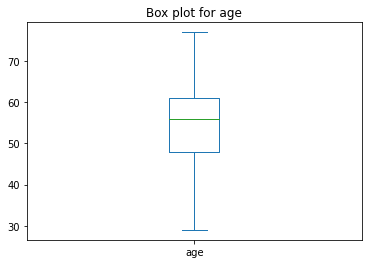

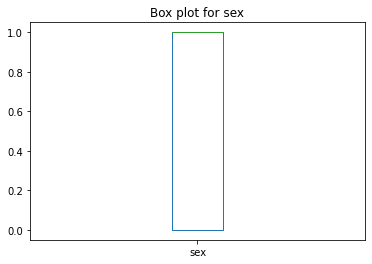

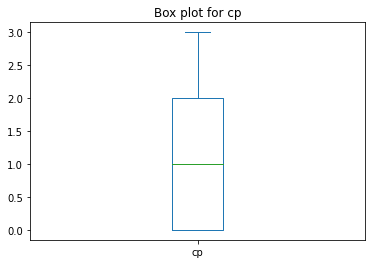

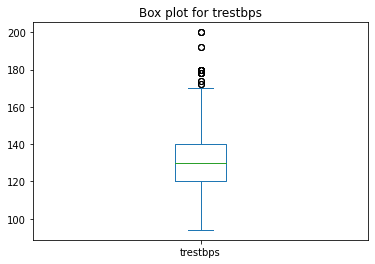

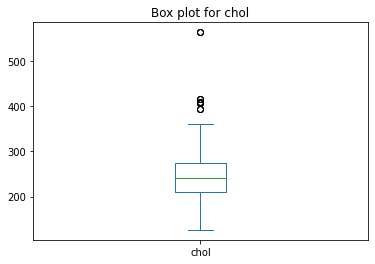

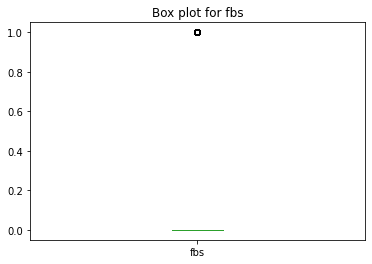

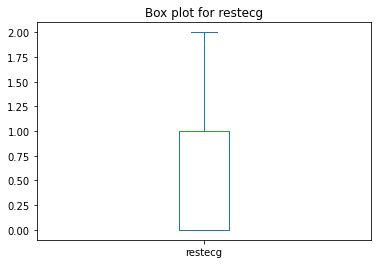

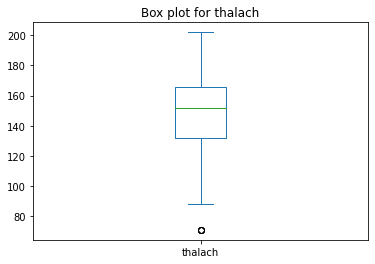

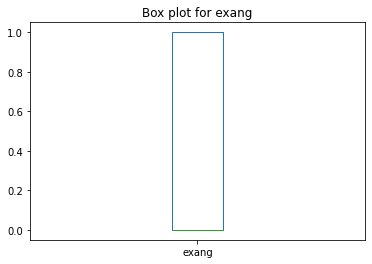

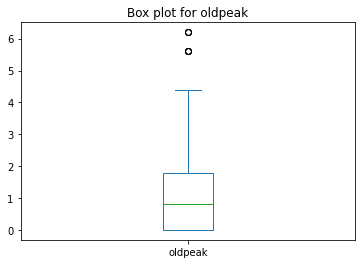

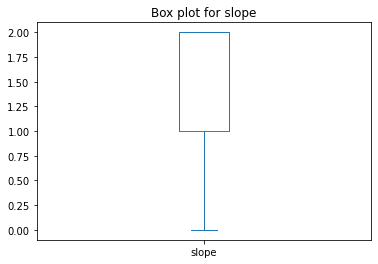

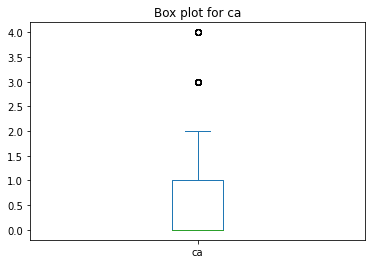

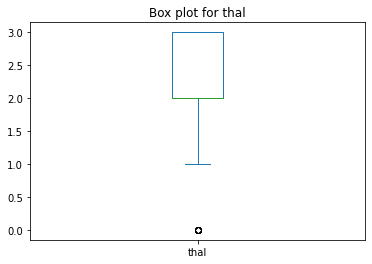

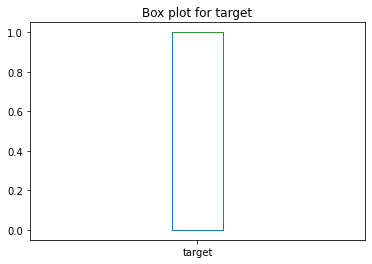

In [0]:
for var in heart_var:
    # Convert column to Pandas and plot box plot
    Heart.select(var).toPandas()[var].plot.box()
    mp.title(f'Box plot for {var}')
    mp.show()

In [0]:
# Outlier Removal
# Function to remove outliers using IQR method
def remove_outliers(df, col):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.approxQuantile(col, [0.25], 0.0)[0]
    Q3 = df.approxQuantile(col, [0.75], 0.0)[0]
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the rows that are outside the bounds
    df_filtered = df.filter((F.col(col) >= lower_bound) & (F.col(col) <= upper_bound))
    
    return df_filtered

# Remove outliers for each column in heart_var
for var in heart_var:
    Heart = remove_outliers(Heart, var)

In [0]:
# Check again how many entries I have now
desc_df = Heart.describe()

# Round each numerical column to 2 decimal places
# Create a list of columns after rounding
rounded_columns = [F.round(F.col(c), 2).alias(c) if c != "summary" else F.col(c) for c in desc_df.columns]

# Select and display rounded columns
desc_df.select(rounded_columns).show()

+-------+-----+-----+-----+--------+------+-----+-------+-------+-----+-------+-----+-----+-----+------+
|summary|  age|  sex|   cp|trestbps|  chol|  fbs|restecg|thalach|exang|oldpeak|slope|   ca| thal|target|
+-------+-----+-----+-----+--------+------+-----+-------+-------+-----+-------+-----+-----+-----+------+
|  count|769.0|769.0|769.0|   769.0| 769.0|769.0|  769.0|  769.0|769.0|  769.0|769.0|769.0|769.0| 769.0|
|   mean|53.43| 0.69| 0.92|  128.69|242.08|  0.0|   0.55| 150.67| 0.32|   0.97| 1.44|  0.5| 2.33|  0.55|
| stddev| 9.23| 0.46| 1.02|   15.31| 44.52|  0.0|   0.52|  22.57| 0.47|   1.05| 0.59| 0.71| 0.57|   0.5|
|    min| 29.0|  0.0|  0.0|    94.0| 131.0|  0.0|    0.0|   88.0|  0.0|    0.0|  0.0|  0.0|  1.0|   0.0|
|    max| 76.0|  1.0|  3.0|   170.0| 360.0|  0.0|    2.0|  202.0|  1.0|    4.0|  2.0|  2.0|  3.0|   1.0|
+-------+-----+-----+-----+--------+------+-----+-------+-------+-----+-------+-----+-----+-----+------+



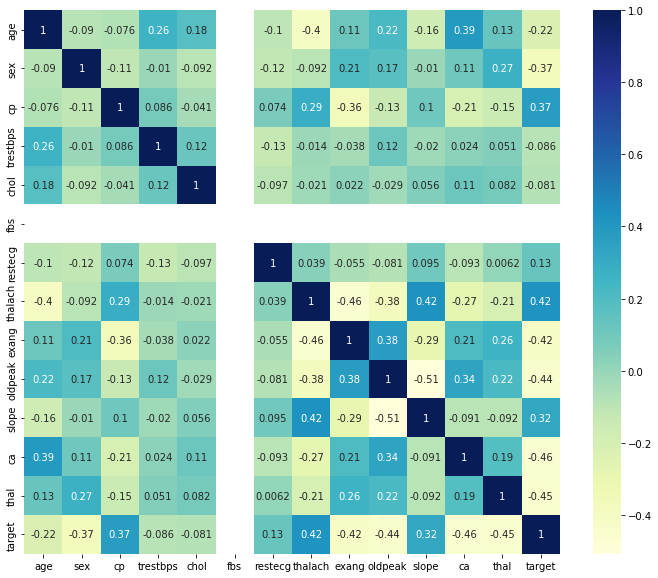

In [0]:
# Correlation Checkup & Removal

#Calculate pairwise correlations
correlation_dict = {}

for col1 in heart_var:
    row = {}
    for col2 in heart_var:
        corr_value = Heart.stat.corr(col1, col2)
        row[col2] = corr_value
    correlation_dict[col1] = row

# Step 3: Convert to Pandas DataFrame
correlation_matrix = pd.DataFrame(correlation_dict)

# Step 4: Plot the correlation heatmap
mp.figure(figsize=(12, 10))
sb.heatmap(correlation_matrix, cmap="YlGnBu", annot=True)
mp.show()

I will remove the column that is gives less than +-0.1  correlation, because with the weak correlation you couldn't see strong effect on model.

In [0]:
Heart = Heart.drop("fbs","trestbps","chol")


In [0]:
# Check if the column is removed
remove_list = ["fbs","trestbps","chol"]
if remove_list not in Heart.columns:
    print("Columns are removed successfully.")
else:
    print("Columns are still exists.")

Columns are removed successfully.


I decided not to run PCA before model fitting because I dont have a huge dataset need to reduce dimention to get more accurate model. Also I have only 10 columns for prediction, so I don't feel like I need for this data training.

# Model Training & Fitting

In [0]:
# Split Dataset
train, test = Heart.randomSplit([0.7, 0.3], seed=42)

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Create a list of feature column names (excluding the target column)
feature_columns = [col for col in Heart.columns if col != 'target']

# Use VectorAssembler to combine all features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features_vec", labelCol="target")

# Create a pipeline to assemble features and apply the model
pipeline = Pipeline(stages=[assembler, lr])

# Fit the model on training data
model = pipeline.fit(train)

# Make predictions on test data
predictions = model.transform(test)

# Evaluate the model using accuracy (or other metrics)
evaluator = BinaryClassificationEvaluator(labelCol="target")
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9174747474747477


# Model Evaluate

In [0]:
predictions.printSchema()


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- features_vec: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
# Confusion Metrix
# Cast both 'prediction' and 'target' columns to DoubleType for consistency
predictions = predictions.withColumn("target", col("target").cast("double"))

# Extracting prediction and actual labels
pred_and_labels = predictions.select("prediction", "target").rdd

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(pred_and_labels)

# Confusion matrix
conf_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
DenseMatrix([[73., 26.],
             [ 6., 94.]])


In [0]:
# Precision, Recall, and F1-Score for class 1 (positive class)
precision = metrics.precision(1.0)  # For positive class
recall = metrics.recall(1.0)  # For positive class
f1_score = metrics.fMeasure(1.0)  # For positive class

# Output the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Precision: 0.7833
Recall: 0.9400
F1-Score: 0.8545


The Logistic Model has 91% accuracy with precision 0.78, recall rate 94%. F1-Score 85%. And I would say this is a very accurate model for disease forecast, because the recall rate is really high, and recall rate is also called True Positive Rate. In the other word, with this model, 94% of prediction postive cases are verified as actual positive too, and the positive cases in disease prediction is extremely important, because this is basically why we create model.